# Fine Tuning For BERT Models with TPU

In [5]:
import tensorflow as tf
import os

# Note that the `tpu` argument is for Colab-only
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

# tensorflow haricinde TPU kullanamazsınız
# bu kod tensorflow sayfasında hazır şekilde bulunuyor
"""
Johnson H not:
notebook ayarlarından TPU'yu seçip kaydedin ve ilk 2 hücreyi çalıştırsın. 
Boşta TPU çekirdeği yok uyarısı alan arkadaşlar 2-3 dakikaya bir bu hücreleri tekrar çalıştırsınlar.
 Uyarı alanlara genelde en geç 5-10 dakika içinde çekirdekler tahsis ediliyor.  O yüzden panik yapmayın
"""

KeyError: ignored

In [ ]:
strategy = tf.distribute.TPUStrategy(resolver) 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import Library

In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/hepsiburada.csv', encoding="utf-8")

In [ ]:
df.head()

,Rating,Review
0,1,3 yıldır tık demedi. :)
1,1,3 yıldır kullanıyorum müthiş
2,1,Ürün bugün elime geçti çok fazla inceleme fırs...
3,1,Almaya karar verdim. Hemencecik geldi. Keyifle...
4,1,Günlük kullanımınızı çok çok iyi karsılıyor kı...


In [ ]:
df.Rating.value_counts()
# 229821 : olumlu, 13676 :olumsuz

1    229821
0     13676
Name: Rating, dtype: int64

In [ ]:
df.Rating.value_counts(normalize=True)

1    0.943835
0    0.056165
Name: Rating, dtype: float64

In [ ]:
df.Rating = df.Rating.map({1:0, 0:1}) # Hedef label ımız olumsuz yorumlar olduğu için olumsuzları 1 yaptık, olumluları 0

In [ ]:
X = df['Review'].values # X ve Y yi array e dönüştürdük. Çok büyük datalarda ML de arrayler daha hızlı çalışır(DL de zaten array olmak zorundaydıç Yoksa çalışmaz)
y = df['Rating'].values

## Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

### Tokenization Example For BERT

https://huggingface.co/dbmdz/bert-base-turkish-uncased

In [ ]:
# Linkte bu tokenizer ın nasıl kullanılacağına dair bilgileri vermişler. Bunları kopyalayıp yapıştırdık alta
# case   : büyük küçük harfe duyarlı şekilde token işlemleri yapar.(Translationda case kullanmak gerekir örneğin virgül, nokta kullanınca anlam değişir. Büyük harf ona göre değişir vs)
# uncase : hepsini küçük harfe dönüştürüp token işlemleri yapar(classification da case e ihtiyaç duymuyoruz o yüzden bunu kullanıyoruz)

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-uncased")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [ ]:
text = "Şentepeli Şükrü abi çok güzel bir insan?😊"
 
tokenizer.tokenize(text)
# Emojiler ML ve DL lerde bunlar ignore ediliyor ve alttaki resimdeki gibi bir şey olduğunda sadece I ve You kalınca(kalp işareti ignore edilince) model yorum yapamaz
# Altta "##epe": word piece tokenizer(eklerine ve köklerine ayırıyordu) yapılmış(eklerine ayırmış)

['sent',
 '##epe',
 '##li',
 'suk',
 '##ru',
 'abi',
 'cok',
 'guzel',
 'bir',
 'insan',
 '?',
 '😊']

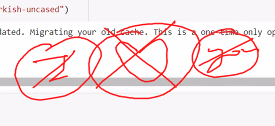

In [ ]:
sentence = "Şentepeli Şükrü abi çok güzel bir insan?😊"
tokens = tokenizer.encode(sentence, add_special_tokens=True) # Sayısal forma dönüştürme
print(tokens)
print(len(tokens))
# Bert modellerinde 2 özel tokenimiz vardı CLS[2] , SEP[3]
# sent: 15955 inci tokene denk geliyormuş 
# 😊: 989 inci tokene denk geliyormuş 
# 14: Kaç tokenden oluştuğu bilgisi

# Bütün yorumlarımın kaç tokenden oluştuğunu öğreneyim ve bütün yorumları aynı boyuta sabitleyeceğiz

[2, 15955, 11679, 2033, 28792, 2239, 8621, 6191, 14533, 1993, 2419, 35, 989, 3]
14


### Fixing token counts of all documents

In [ ]:
# For every sentence...
max_token = []
for sent in X:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    
    input_ids = tokenizer.encode(sent, add_special_tokens=True) # add_special_tokens=True: CLS[2] , SEP[3]
    max_token.append(len(input_ids))

print('Max sentence length: ', max(max_token))
# Corpusumdaki her bir yorum tokenden oluşuyor ve En uzun yorum kaç tokenden oluşuyor(546) bilgilerini göreceğiz 

Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  546


In [ ]:
list = [5, 10, 8, 9, 12, 15, 4]
print(np.array(list) <= 10)
print(sum(np.array(list) <= 10)/len(list))

# Yüzde 95 inde bilgi kaybı olmasın demiştik önceden. Yine bu mantık anlatılıyor burada

[ True  True  True  True False False  True]
0.7142857142857143


In [ ]:
np.array(max_token).mean() # Corpusumdaki yorumlar ortalama 39 tokenden oluşuyor

39.53032686234327

In [ ]:
sum(np.array(max_token) < 160) / len(max_token) # Johnson H: Burada ben 160(boyut) a karar kıldım

0.9849115184170647

### Transformation Vectors to Matrices

In [ ]:
# Bert model 3 tane ayrı ayrı vektör ister. Burada encode yerine(yukarıda encode kullandık) encode_plus kullanıyoruz
sentence = "Şentepeli Şükrü abi çok güzel bir insan?😊"
tokens = tokenizer.encode_plus(sentence, add_special_tokens=True)
print(tokens)
# input_ids: tokenlerime bir kimlik numarası veriyor
# token_type_ids: translation veya question & answers şarda .. modele verilen textlerin hangisi input, hangisi output olduğunu belirliyordu. Bu classification da ve sentiment analizde kullanmayacağız
# attention_mask: Position embedding. Bunların gerçek boyutlarını(uzunluğunu) öğrenme hem de pozition bilgiler.

# Bert modelin benden istediği 3 ayrı vektörü elde ediyorum. Bunun için "encode_plus" ı kullanıyorum

{'input_ids': [2, 15955, 11679, 2033, 28792, 2239, 8621, 6191, 14533, 1993, 2419, 35, 989, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
"""
class chat: max_token listesi inceleme
import numpy as np
from scipy import stats

arr = np.array(max_token)
 
print("Descriptive analysis")
print("Document Size \t=", arr.shape[0])
print("Doc Token Count\t=", arr)

# measures of central tendency
print("Measures of Central Tendency")
print("Mean \t\t=", arr.mean())
print("Median \t\t=", np.median(arr))
print("Mode \t\t=", stats.mode(arr)[0][0])

# measures of dispersion
print("Measures of Dispersion")
print("Minimum \t=", arr.min())
print("Maximum \t=", arr.max())
print("Range \t\t=", arr.ptp())
print("Variance \t=", arr.var())
print("Standard Deviation =", arr.std())
"""

In [ ]:
# Her birini 160 tokene sabitlemeliyiz
tokens = tokenizer.encode_plus(sentence, max_length=160, truncation=True,
                              padding='max_length', add_special_tokens=True)
tokens
# max_length=160 bunu atadıktan sonra bunu padding in karşısına yazacağız "max_length" i. Yoksa hata alırsınız
# input_ids,token_type_ids, attention_mask i 160 boyuta sabitledi
# Tokenleştirme işlemini bu kod ile yapmış olduk
# truncation=True : Kesme işlemi gerekirse yap

# class chat soru: Hocam burada 0 ları sona ekledi?
# Johnson H: DL de başa eklerken burada sona ekliyor

{'input_ids': [2, 15955, 11679, 2033, 28792, 2239, 8621, 6191, 14533, 1993, 2419, 35, 989, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
# Vektörlere dönüştürdük. Ama benim 24300 yorumum var
# Bu elde ettiğim vektörleri matrise dönüştüreceğim
# HEr bir yorumu alıp bir matris içerisinde birleştireceğiz
seq_len = 160
num_samples = len(X) # gözlem sayım, satır sayım, yorum sayım # 243000

# 0 lardan oluşan 2 ayrı matris oluşturuyoruz. 160 feature, 243000 satırlık matris
Xids = np.zeros((num_samples, seq_len))
Xmask = np.zeros((num_samples, seq_len))

# class chat soru: toekn_type ids i kullandığımız için mi eklemedik. Kullansak yapacak mıyız?
# Johnson H: Kullanmadığımız için almadık ama translation yapacaksanız onun içinde bir matris oluşturmanız gerekirdi
# .. toekn_type ids zaten "0" lardan oluşacağı için hep modele bir faydası yok

In [ ]:
Xids[:2]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [ ]:
Xmask[:2]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [ ]:
print(tokens['input_ids'])
print(tokens['attention_mask'])

[2, 15955, 11679, 2033, 28792, 2239, 8621, 6191, 14533, 1993, 2419, 35, 989, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
# ilgili matrisimizdeki ilgili(kaçıncı yoruma denk geliyorsa) satıra ilave ediyorum. Xids[0]: Xid lerin ilk satırları
Xids[0] = tokens['input_ids']        
Xmask[0] = tokens['attention_mask']

In [ ]:
Xids[0]

array([2.0000e+00, 1.5955e+04, 1.1679e+04, 2.0330e+03, 2.8792e+04,
       2.2390e+03, 8.6210e+03, 6.1910e+03, 1.4533e+04, 1.9930e+03,
       2.4190e+03, 3.5000e+01, 9.8900e+02, 3.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e

In [ ]:
Xmask[0]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [ ]:
# Üsttekileri bütün corpus a uygulayalım

def transformation(X):
  # set array dimensions
  seq_len = 160
  num_samples = len(X)

  # initialize empty zero arrays
  Xids = np.zeros((num_samples, seq_len))
  Xmask = np.zeros((num_samples, seq_len))

    
  for i, phrase in enumerate(X):
      tokens = tokenizer.encode_plus(phrase, max_length=seq_len, truncation=True,
                                      padding='max_length', add_special_tokens=True) 
      
      # assign tokenized outputs to respective rows in numpy arrays
      Xids[i] = tokens['input_ids']
      Xmask[i] = tokens['attention_mask']
  return Xids, Xmask

# Xids[i] ye karşılık gelen tokens['input_ids'] mizi 
# Xmask[i] ye karşılık gelen tokens['attention_mask'] mizi birleştirdik
  # enumerate: o yorumun, kaçıncı yoruma denk geldiğini tespit edeceğiz enumerate yardımıyla

In [ ]:
Xids_train, Xmask_train = transformation(X_train) 
Xids_test, Xmask_test = transformation(X_test)

In [ ]:
print("Xids_train.shape  :", Xids_train.shape)
print("Xmask_train.shape :", Xmask_train.shape)
print("Xids_test.shape   :", Xids_test.shape)
print("Xmask_test.shape  :", Xmask_test.shape)

Xids_train.shape  : (219147, 160)
Xmask_train.shape : (219147, 160)
Xids_test.shape   : (24350, 160)
Xmask_test.shape  : (24350, 160)


In [ ]:
y_train # labelımızı da matrise dönüştürmemiz lazım. vektör olarak bırakamayız

array([0, 0, 0, ..., 0, 1, 0])

In [ ]:
labels_train = y_train.reshape(-1,1)  # -1: satır sayısı ne ise kendin ayarla, 1: feature/sütun sayısı
labels_train
# labelımızı tek boyutlu bir matrise dönüştürmüş olduk

array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [0]])

In [ ]:
y_test

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
labels_test = y_test.reshape(-1,1)
labels_test

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [ ]:
from tensorflow.keras.utils import to_categorical

l = np.array([0, 1, 3, 5, 4, 2])
to_categorical(l, 6) 

# Burayı not olarak yazdık Label ınız 2 den fazla class a aitse
# "from tensorflow.keras.utils import to_categorical" u kullanarak l = y_test/y_train inizi veriyorsunuz to_categorical, istediğiniz matris boyutuna getiriyor
# .. Eğer bunu üstte benim modelim için kullansaydık matrisim 2 boyutlu olurdu ve sigmoid yerine softmax kullanmak zorunda kalırdık


array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

## Transformation Matrix to Tensor

In [ ]:
# 2. ders
# Tensor: Birden fazla matrisin bir araya gelerek oluşturduğu yapı
# Bert modelleri bizden bunları tensor olarak istiyor

In [ ]:
import tensorflow as tf
dataset_train = tf.data.Dataset.from_tensor_slices((Xids_train, Xmask_train, labels_train))
dataset_train
# Xids_train, Xmask_trainn, labels_train i tensor içerisinde birleştirecek
# Yani her birini tensor yapacak(3 tane tensor döndürecek)
# Aynı şeyi test seti için de yapalım

<TensorSliceDataset element_spec=(TensorSpec(shape=(160,), dtype=tf.float64, name=None), TensorSpec(shape=(160,), dtype=tf.float64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>

In [ ]:
dataset_test = tf.data.Dataset.from_tensor_slices((Xids_test, Xmask_test, labels_test))
dataset_test

# Bunları tensorlere dönüştürüp text e verdiğim zaman bert şunu der, bunların boyutları aynı ve benim için aynı şey bunlar
# .. Bunların hangisi input id, hangisi attention mask diye sorar

<TensorSliceDataset element_spec=(TensorSpec(shape=(160,), dtype=tf.float64, name=None), TensorSpec(shape=(160,), dtype=tf.float64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>

In [ ]:
def map_func(Xids, Xmask, labels):
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': Xids, 'attention_mask': Xmask}, labels
# input_ids, attention_mask: Bu yazdığımız isimler yukarı tokenizer(tokenleri ayırma) işlemi yaptığımız isimler ile aynı olmalı
# NOT: Bunu süslü parantez içerisinde belirliyoruz
# Burada input ve output ayrımını yapıyoruz
# input: {'input_ids': Xids, 'attention_mask': Xmask}
# output: labels

In [ ]:
# then we use the dataset map method to apply this transformation
dataset_train = dataset_train.map(map_func)
dataset_test = dataset_test.map(map_func)

In [ ]:
dataset_train

<MapDataset element_spec=({'input_ids': TensorSpec(shape=(160,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(160,), dtype=tf.float64, name=None)}, TensorSpec(shape=(1,), dtype=tf.int64, name=None))>

In [ ]:
dataset_test

<MapDataset element_spec=({'input_ids': TensorSpec(shape=(160,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(160,), dtype=tf.float64, name=None)}, TensorSpec(shape=(1,), dtype=tf.int64, name=None))>

## Batch Size and Shuffle Train Dataset

In [ ]:
# tensorleri de modele batch size a bölüp vermek lazım
# Bert modelini geliştiren developerların önerisi: batch_size: 16,32 deneyin
# Ancak overfit varsa 64 vs de deneyebilirsiniz. Ancak batch_size küçük oldukça model daha iyi öğrenmeye meyillidir

In [ ]:
batch_size = 32 # 16, 32

# batch_size 
# fit into a batch of 32
train_ds = dataset_train.batch(batch_size) # Gözlemlerin yeri sabit olduğundan metricler için kullanacağız. 
val_ds = dataset_test.batch(batch_size)
# Hem train seti ve validation setini 32 li paketlere böldük ama altta extra bir şey yaptık

length = len(X_train)
train_ds2 = dataset_train.shuffle(buffer_size = length, reshuffle_each_iteration=True).batch(batch_size) 

# train_ds
# shuffle: Tensorlar arasında her epoch da karılma işlemi olmasını istiyorsam bunu kullanıyorum
# buffer_size = length : Kaçlı paketlere bölüp karıştırayım. Dökümanda datanın kendi boyutuna eşit sayı verirseniz en iyi sonucu alırsınız diyor. O yüzden buffer_size a datanın kendi boyutunu verdik
# reshuffle_each_iteration=True: Her iterasyonda dataseti kendi içinde karılsın mı 
# Buffer size boyutu train datasının boyutuyla aynı olduğunda eğitim aşamasında train datası en iyi şekilde karıştırılır.

# Eğitim aşamasında train_ds2, predict aşamasında train_ds kullanacağım(Çünkü train_ds2 yi predict te kullansaydık predict te kötü sonuçlar gelir(Aşağıda göreceğiz))

## Creating Model

In [ ]:
def create_model():
    from transformers import TFAutoModel  # AutoModel başına TF yazabiliyoruz. Notebook u dışardan göre biri Tensorflow un Tensorlarını mı kullanmış bilsin diye başına TF yazdık
    model = TFAutoModel.from_pretrained("dbmdz/bert-base-turkish-uncased")
    input_ids = tf.keras.layers.Input(shape=(160,), name='input_ids', dtype='int32')
    attention_mask = tf.keras.layers.Input(shape=(160,), name='attention_mask', dtype='int32')

    embeddings = model.bert(input_ids=input_ids, attention_mask=attention_mask)["pooler_output"] #[1]

    x = tf.keras.layers.Dense(160, activation='relu')(embeddings)  # dense layer a word_embedding bilgilerini aktar. Aktaracağım layer ı da tuple içinde ("embeddings") yazıyorum.(functional API tarzı(Önceden sequential tarzı ile yazıyorduk))
    x = tf.keras.layers.Dropout(0.1, name="dropout")(x) #0.1 # x deki bilgileri dropout a aktardık
    y = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(x) # Üstteki x bilgileri de buraya aktardık. Her bir token hangi tokenlerle kullanılmış bu kısımda görüyor. Eğer son bir revize yapılacaksa bu kısımda yapılıyor

    return tf.keras.Model(inputs=[input_ids, attention_mask], outputs=y) # inputlarımı ve outputumu veriyoruz

# Modeli tanımlıyoruz burada. Tensorflow un kendi sayfasında kullandığı modeli aldık yapıştırdık buraya direk
#  dtype='int32': Bert modelleri "int32" de çalışır(Float tı normalde)
# embeddings: Model üzerinde eğitilmiş hazır olan tokenleri çekme kısmı
# ... input_ids=input_ids, attention_mask=attention_mask: dataya input u verdik ve her bir tokene karşılık gelen word_embeddingleri çekeceğiz
# ["pooler_output"]: bert modellerin üzerinde eğitildiği ilgili ....
# [1]: Bu bert modelimizin 1. katmanı olduğu için "pooler_output" yerine "1" de yazabilirsiniz
# Üstte to_categorical kullansaydık son kısımda " 1, activation='sigmoid' " yerine  "2, activation='softmax' " yazmalıydık
# outputs=y : buradaki y, bir nevi y_pred ler bunu eğitim aşamasındaki y ler ile karşılaştırıp loss lar elde edecek

"""
    from transformers import TFAutoModel
    model = TFAutoModel.from_pretrained("dbmdz/bert-base-turkish-uncased")
# Bu 2 sini her zaman fonksiyon içinde kullanın
"""

In [ ]:
with strategy.scope():
  optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5) #3e-5, 5e-5
  loss = tf.keras.losses.BinaryCrossentropy()
  recall = tf.keras.metrics.Recall()
  model3 = create_model()
  model3.compile(optimizer=optimizer, loss=loss, metrics=[recall])

  # NOT: initializing TFBertModel: ['mlm___cls', 'nsp___cls'] uyarısını dikkate almayın

Some layers from the model checkpoint at dbmdz/bert-base-turkish-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
#pd.Series(y).value_counts(normalize=True)

In [ ]:
#weights = {0:0.05, 1:0.95}

In [ ]:
model3.summary()
# 110,740,545 parametre ile işlem görmüş data

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 160)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 160)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  110617344   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 160,                                           

In [ ]:
history = model3.fit(
    train_ds2, validation_data= val_ds, class_weight= {0:1, 1:4},
    epochs=1) # epoch= 2 or 3 # Dökümanda "2 ve ya 3 den daha fazla epoch yaptırmayın overfit e gider" der. Overfit i epochs=1 ile engellediğimiz için 1 epoch yaptık
# epoch=1 de karışma işlemi olmayacak/gerek kalmayacak??? Evet ama her zaman böyle olmayacak

# Burada train_ds2 yi kullandık 
# class_weight= {0:1, 1:4} : Ağırlıklandırmayı 1 e 1 yapmaya gerek yok. Burada bu şekilde yapmayı tercih ettik. Güzel sonuçlar aldığımızı göreceğiz
# Bu işlem, CPU : 180 saat, GPU: 2-3 saat, TPU: 10 dk sürüyor

6849/6849 [==============================] - 808s 105ms/step - loss: 0.1779 - recall: 0.8232 - val_loss: 0.0794 - val_recall: 0.8611


## Model evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model3.predict(val_ds) >= 0.5


print(classification_report(y_test, y_pred))

# Bu kadar dengesiz bir datada 0.71 precision ı hiç bir metod da yakalayamazsınız.
# recall 0.86 gelmiş(0.91 e kadar çıkıyor skor. Bir kaç defa daha çalıştırırsanız)
# Modeli her çalıştırdığınızda bir değişkene kaydedelim ki o skorları kaybetmeyelim

761/761 [==============================] - 35s 38ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     22982
           1       0.71      0.86      0.78      1368

    accuracy                           0.97     24350
   macro avg       0.85      0.92      0.88     24350
weighted avg       0.98      0.97      0.97     24350



In [ ]:
y_train_pred = model3.predict(train_ds) >= 0.5


print(classification_report(y_train, y_train_pred)) 

6849/6849 [==============================] - 205s 30ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    206839
           1       0.76      0.91      0.83     12308

    accuracy                           0.98    219147
   macro avg       0.88      0.95      0.91    219147
weighted avg       0.98      0.98      0.98    219147



In [ ]:
y_train_pred2 = model3.predict(train_ds2) >= 0.5


print(classification_report(y_train, y_train_pred2)) 
# prediction da train_ds2 kullansaydık, sonuçlarımız böyle saçmasapan gelirdi

6849/6849 [==============================] - 195s 28ms/step
              precision    recall  f1-score   support

           0       0.94      0.93      0.94    206839
           1       0.06      0.07      0.06     12308

    accuracy                           0.88    219147
   macro avg       0.50      0.50      0.50    219147
weighted avg       0.89      0.88      0.89    219147



In [ ]:
# Ağırlıklandırma yapmadan skorlarımız
# Test: 0,61 0.75
# Train: 0.85, 0.90 idi ... Burada;
# Test : 0.79      0.80
# Train: 0.85      0.85  oldu

# Bu kadar dengesiz bir datada(%96 ya, %4) skorları ML, DL de elde edemezsiniz. O yüzden BERT i tercih edin

Unweighted model

TEST SET
                
                precision    recall  f1-score   support

           0       0.99      0.97      0.98     22987
           1       0.79      0.80      0.80      1365

  

TRAIN SET

                precision    recall  f1-score   support

           0       1.00      0.97      0.99    206825
           1       0.85      0.85      0.85     12311

    


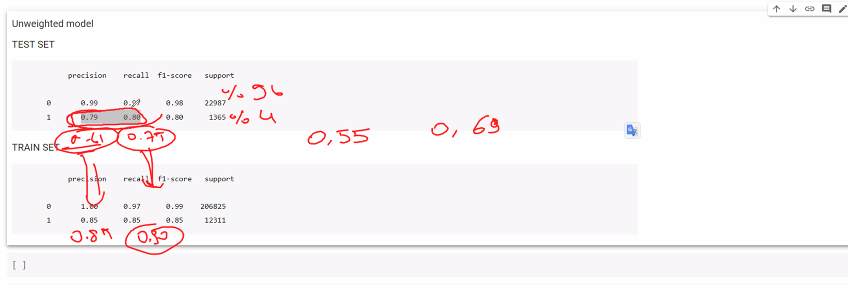

761/761 [==============================] - 24s 28ms/step


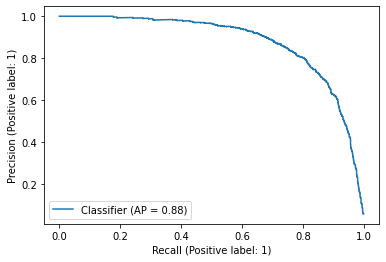

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt

y_pred_proba = model3.predict(val_ds)

PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba)
plt.show();

# Model performansı %88, DL de %72 civarındaydı

In [ ]:
# 3. ders
model3.save("/content/drive/MyDrive/sentiment_model.h5")

In [ ]:
from tensorflow.keras.models import load_model
model4 = load_model('/content/drive/MyDrive/sentiment_model.h5')

In [ ]:
# initialize tokenizer from transformers
from transformers import AutoTokenizer, TFAutoModel

tokenizers = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-uncased")

def prep_data(text):
    # tokenize to get input IDs and attention mask tensors
    tokens = tokenizers.encode_plus(text, max_length=160,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True,
                                   return_tensors='tf')  # her bir yorumu otomatik olarak tensor a dönüştür
  
    return {'input_ids': tokens['input_ids'],      
            'attention_mask': tokens['attention_mask']} 

# Tensor olarak dönüştürdüğüm için return ler tensor olarak gelecek ve prediction için hazır olmuş olacak

In [ ]:
review1 = "çok beğendim herkese tavsiye ederim"
review2 = "süper ürün aynı gün elime geçti"
review3 = "büyük bir hayal kırıklığı yaşadım bu ürünü bu markaya yakıştıramadım"
review4 = "kelimelerle tarif edilemez"
review5 = "tasarımı harika ancak kargo çok geç geldi ve ürün açılmıştı hayal kırıklığı gerçekten"
review6 = "hiç resimde gösterildiği gibi değil"
review7 = "kötü yorumlar gözümü korkutmuştu ancak hiçbir sorun yaşamadım teşekkürler"
review8 = "hiç bu kadar kötü bir satıcıya denk gelmemiştim ürün siparişimi iptal ediyorum"
review9 = "tam bir fiyat performans ürünü"
review10 = "beklediğim gibi çıkmadı"
review11 = "on numara beş yıldız"
review12 = "bu kargoyu biran önce bırakın. yoksa üründe sıkıntı yok"
review13 = "televizyonun görüntü kalitesi çok kötü, dün akşam evde arkadaşlarla toplandık. yedik, içtik, sohbet ettik. Sonra televizyonda Türkiye - İngiltere maçını seyrettik. "
review14 = '1 gün gibi kısa bir sürede elime geçti. Ve bu fıyata süper bir ürün tavsiye ederim. Lakin eli büyük olan kişiler daha büyük modelini tercih edebilirler ortaboy ürün. Teşekkürler '
review15 = "alınca anlarsın anyayı konyayı"
review16 = "çöpe atacak paran varsa al"
review17= "Telefon çok da kötü değil"
review18 = "al da gününü gör"
review19 = "Ürün harika ama satıcı ve kargo berbat"
review20 = "kargo süper ama ürün berbat"
review21 = "Aldigim TV cok kaliteli diye dusunmustum, sonradan cok da iyi bir TV olmadigini dusundum, ama neyse yine de memnunum."
review22 = "😊"
review23 = ":)"
review24 = "I ❤️ you"
review25 = 'telefon kesinlikle bu parayı hak etmiyor. yeni hiç bir özelliği yok. ancak küçük ekran sevenler için iyi bir telefon'
review26 = 'müthiş bir telefon ama bu parayı hak etmiyor'
reviews = [review1, review2, review3, review4, review5, review6, review7, review8, review9, review10, review11, review12, review13, review14, review15, review16, review17, 
           review18, review19, review20, review21, review22, review23, review24, review25, review26] 

In [ ]:
probs = []
for i in reviews:

  in_tensor = prep_data(i)

  prob = model4.predict(in_tensor)[0][0]

  probs.append(prob)

  # her aşamada aldığım olasılığı probs içine ata

1/1 [==============================] - 0s 192ms/step


In [ ]:
in_tensor
# in_tensor istediğim formata gelmiş(tf.Tensor, shape=(1, 160), dtype=int32)

{'input_ids': <tf.Tensor: shape=(1, 160), dtype=int32, numpy=
 array([[   2, 2783, 5830, 1993, 3084, 2201, 2011, 8663, 2303, 9567,    3,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,

In [ ]:
model4.predict(in_tensor) # Sonucu 2 boyutlu döndürüyor

1/1 [==============================] - 0s 192ms/step


array([[0.71006334]], dtype=float32)

In [ ]:
model4.predict(in_tensor)[0][0]  # 2 boyutlu array in içerisinden bu değri çekmek için [0][0] yaptık sona

1/1 [==============================] - 0s 188ms/step


0.71006334

In [ ]:
probs

[0.0013206474,
 0.0020754011,
 0.9985483,
 0.013375679,
 0.98778343,
 0.99673295,
 0.009441297,
 0.9988051,
 0.001162276,
 0.9985416,
 0.0016913788,
 0.03950867,
 0.9977518,
 0.0034353388,
 0.064463675,
 0.7699374,
 0.11045295,
 0.02207765,
 0.37644976,
 0.9952983,
 0.18084016,
 0.009348301,
 0.012465779,
 0.016036171,
 0.9640639,
 0.71006334]

In [ ]:
classes  = (np.array(probs) >= 0.5).astype("int")
classes

array([0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1])

In [ ]:
my_dict = {"Review":reviews, "prob":probs, "classes":classes}

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.DataFrame(my_dict)

# 4. indexte hayal kırıklığı nın olumsuzda ağırlıklı bir keyword olduğunu öğrenmiş model "harika" geçmesine rağmen olumsuz olarak tahmin etmiş
# Ürün harika ama satıcı ve kargo berbat : ürüne yapılan yorumu daha çok dikkate almış 
# kargo süper ama ürün berbat: ürüne yapılan yorumu dikkate almış

# al da gününü gör, "anyayı konyayı"? neden bilemedi? Altta bakacağız

# class chat soru: ben de bazı sonuçlar değişik hocam
# Johnson H: karma yaptığı için tokenlere atanan katsayılarda farklılıklar olabilir. Ayrıca modelimizde ağırlıklandırma yaptığımız için
# .. bazı olumlu yorumları da olumsuz görebiliriz çünkü olumsuzları tahmin etmeye ağırlık ver demiştik

,Review,prob,classes
0,çok beğendim herkese tavsiye ederim,0.001321,0
1,süper ürün aynı gün elime geçti,0.002075,0
2,büyük bir hayal kırıklığı yaşadım bu ürünü bu markaya yakıştıramadım,0.998548,1
3,kelimelerle tarif edilemez,0.013376,0
4,tasarımı harika ancak kargo çok geç geldi ve ürün açılmıştı hayal kırıklığı gerçekten,0.987783,1
5,hiç resimde gösterildiği gibi değil,0.996733,1
6,kötü yorumlar gözümü korkutmuştu ancak hiçbir sorun yaşamadım teşekkürler,0.009441,0
7,hiç bu kadar kötü bir satıcıya denk gelmemiştim ürün siparişimi iptal ediyorum,0.998805,1
8,tam bir fiyat performans ürünü,0.001162,0
9,beklediğim gibi çıkmadı,0.998542,1


In [ ]:
count=0
for i in X_train:
  if "gününü gör" in i.lower():
    count+=1
print(count)

# gününü gör: Data bunu train de görmemiş hiç . Model bunun olumsuz bir yorum içinde kullanıldığını öğrenememiş

0


In [ ]:
count=0
for i in X_train:
  if "anyayı konyayı" in i.lower():
    count+=1
print(count)

# anyayı konyayı: Data bunu train de görmemiş hiç . Model bunun olumsuz bir yorum içinde kullanıldığını öğrenememiş

0


In [ ]:
count=0
for i, j in enumerate(X):
  if "çöpe atacak paran" in j.lower() and y[i]==1:
    count+=1
    print(i)
print(count)

158068
218693
2


In [ ]:
X[158068]

'beş para etmez çöpe atacak paranız varsa alın'

In [ ]:
# class chat: tokenizationda türkceyi yükledik ama ingilizce yorumu da bildi, ingilizce default mu acaba,baska dilde yorum olsaydi onda da tahmin yapabilir miydi?
# Johnson H: Bert Turk, google ın sağladığı datalar üzerinde eğitmiş ama ingilizce yorumu yakalamış olması ile ilgili net bir şey söyleyemem
# .. ama bert-turk ün eğitiminin tamamen türkçe üzerinde olduğunu biliyorum. 
# .. class chat cevap : İngilizce olduğundan değil de data içerisinde var olduğundan olabilir(johnson H: bu da olabilir evet)


# Bundan sonra hep BERT modellerini ya da hazır modelleri tercih etmemiz daha iyi olur.
# Ders sonu : TSI: 13:19